In [3]:
#Data Analysis
import matplotlib
matplotlib.style.use('seaborn-bright')
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("svg") 
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import pickle

#Data Preprocessing and Feature Engineering
import librosa
import librosa.display
import IPython.display as ipd
#!pip install audiolazy
#from audiolazy import lpc

#Model Selection Evaluation and Test
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.externals import joblib

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


<h1><center>PREPROCESSING

<h3>PRE-EMPHASIS

In [4]:
def pre_emphasis(signal,pre_emphasis=0.97):
    emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])
    return emphasized_signal

<h3>Framing

In [5]:
def framing(signal,sample_rate=16000,frame_size=0.025,step_size=0.010):
        frame_length = int(np.floor(frame_size * sample_rate))
        frame_shift = int(np.floor(step_size * sample_rate))
        signal_length=len(signal)
        hamwin = np.hamming(frame_length)
        num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_shift))
        frames = np.zeros([frame_length, num_frames])
        indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_shift, frame_shift), (frame_length, 1)).T
        frames=signal[indices]    
        frames = frames*hamwin
        return frames

<h3 >Deframing

In [6]:
def deframing(frames,sample_rate=16000,frame_size=0.025,step_size=0.010):
        frame_length = int(np.floor(frame_size * sample_rate))
        frame_shift = int(np.floor(step_size * sample_rate))
        hamwin = np.hamming(frame_length)
        num_frames=frames.shape[0]
        indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_shift, frame_shift), (frame_length, 1)).T
        padlen = (num_frames - 1) * frame_shift + frame_length
        nwsignal=np.zeros(padlen)
        remv_win=np.zeros(padlen)
        e=0.0000001
        for i in range(num_frames):
          remv_win[indices[i,:]]=remv_win[indices[i,:]]+hamwin+e
          nwsignal[indices[i,:]]=nwsignal[indices[i,:]]+frames[i,:]
        nwsignal=nwsignal/remv_win
        return nwsignal

<h3>Zero Crossing Rate


In [7]:
def Zero_crossing_rate(frame):                           
      zr = 0
      for k in range(1, len(frame)):
            if (0.5*abs(np.sign(frame[k]) - np.sign(frame[k - 1])))==1:
                zr+=1
      return zr/len(frame)

<h3>STE

In [8]:
def short_time_Energy(frames):
    return sum( [abs(x)**2 for x in frames] ) 

<h3>Voice Activity Detection VAD

In [9]:
def VAD(signal,sample_rate):
    frames=framing(signal,sample_rate)
    frame_size=0.025
    win_size = int(np.floor(frame_size * sample_rate))
    framess=np.array([])
    index=[]
    for i,f in enumerate(frames):
        if (short_time_Energy(f)<0.005 and Zero_crossing_rate(f)>0.10):
            index.append(i)
    framess=np.delete(frames,index,0)
    new_signal=deframing(framess)
    return new_signal

In [10]:
dataset = "/content/drive/My Drive/50_speakers_audio_data/"


<h1><center>Features Extraction

<h3>MFCC

In [11]:
def get_MFCCs(signal, sample_rate=16000,duration=30):
    
    sample=int((sample_rate*duration)/3)
    if len(signal) >= sample:
         signal = signal[:sample]
    mfcc = librosa.feature.mfcc(signal, sr=sample_rate,n_mfcc=20,hop_length=int(0.010 *sample_rate), n_fft = int(0.025 * sample_rate))
    #print(mfcc.shape)
    #delta_mfcc=librosa.feature.delta(mfcc,order=1)
    mfcc_features= np.mean(mfcc,1)
    mfcc_features= (mfcc_features-np.mean(mfcc_features))/np.std(mfcc_features)
    
    return mfcc_features.T

<h3>LPC

In [ ]:
def LPC(signal):
    filt = lpc(signal,order=13)
    lpc_features =  filt.numerator[1:]
    return np.array(lpc_features)

<h1>Data Preparation

In [16]:
sample = int((16000*60)/2)
dataset = "C:/Users/zenno/Downloads/audio_darija/"
json_path ="/content/drive/My Drive/Speaker Recognition PFE/json_data_mffcs_darija5.json"

In [ ]:
def pre_processing(dataset_path, json_path):
   
    data = {
        "speakers": [],
        "speaker_labels": [],
        "MFCC": [],
    }

    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        if dirpath is not dataset_path:

            label = dirpath.split("/")[-1]
            data["speakers"].append(label)
            print("\nProcessing: '{}'".format(label))

            for f in filenames:
                    file_path = os.path.join(dirpath, f)

                    signal, sample_rate = librosa.load(file_path,sr=16000)
                          
                    #Pre_emphasis
                    signal = pre_emphasis(signal)

                    #VAD
                    signal = VAD(signal,sample_rate)

                    sample=int((sample_rate*30)/3)
                    if len(signal) >= sample:
                            signal = signal[:sample]
                          
                    # extract MFCC
                    mfccs = LPC(signal)

                    # store data
                    data["MFCC"].append(mfccs.T.tolist())
                    data["speaker_labels"].append(i-1)
                    print("{}: {}".format(file_path, i-1))

    # save MFCC and labels in json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)

In [ ]:
pre_processing(dataset,json_path)

<h1> Load & Split Dataset




In [13]:
def features_target(json_path):

    with open(json_path, "r") as jp:
        data = json.load(jp)

    X = np.array(data["MFCC"])

    y = np.array(data["speaker_labels"])

    return X, y

In [17]:
X,y=features_target(json_path)

In [18]:
def split_dataset(json_path, test_size=0.25):

    X, y = features_target (json_path)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    #scaler = preprocessing.StandardScaler().fit(X_train)
    #X_train_transformed = scaler.transform(X_train)
    #X_test_transformed = scaler.transform(X_test)

    return X_train , y_train, X_test, y_test

In [19]:
X_train,y_train,X_test,y_test=split_dataset(json_path)
print(X_train.shape)
print(y_test.shape)

(3161, 20)
(1054,)


<h1>Classification models

<center><h1>SVM</center>

<h3>POLY Kernel

In [ ]:
model1 = SVC(kernel='poly', C = 10.0, gamma=0.1, probability=True)
model1.fit(X_train, y_train)

SVC(C=10.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='poly',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

<h3>RBF Kernel

In [20]:
model1 = SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
model1.fit(X_train, y_train)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

<h1><center>RandomForest (RF)








In [25]:
model2= RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
model2.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
# Grid Search
from sklearn.model_selection import GridSearchCV
# Parameter Grid
param_grid = {'n_estimators': [100,200,250,300,350,400]}

# Make grid search classifier
clf_grid = GridSearchCV( RandomForestClassifier(), param_grid, verbose=1)

# Train the classifier
clf_grid.fit(X_train, y_train)

# clf = grid.best_estimator_()
print("Best Parameters:\n", clf_grid.best_params_)
print("Best Estimators:\n", clf_grid.best_estimator_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  2.9min finished


Best Parameters:
 {'n_estimators': 100}
Best Estimators:
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


<h2><center>K-NearestNeighborsClassifier (KNN)




In [ ]:
model3=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=1,
                     weights='uniform')
model3.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=1,
                     weights='uniform')

<h3> Save models

In [ ]:
pickle.dump(model3, open("/content/drive/My Drive/model_knn_mfcc_darija.sav", 'wb'))

In [ ]:
loaded_model = pickle.load(open("/content/drive/My Drive/model_svm.sav", 'rb'))

In [ ]:
# Save
joblib.dump(model, '/content/drive/My Drive/trainedRF_MFCC.joblib')
#Load
svclassifier = joblib.load('/content/drive/My Drive/trainedRF_MFCC.joblib')

<h1>Prediction 

In [21]:
predicted1 = model1.predict(X_test)

In [26]:
predicted2=model2.predict(X_test)

In [ ]:
predicted3=model3.predict(X_test)

In [27]:
print('Predicted labels:', predicted2[:20], 'True labels:', y_test[:20].tolist())

Predicted labels: [45 11  0 11 39  3 29  8 55 41 31 57 14 12 46 69 43  9 31 67] True labels: [45, 11, 0, 11, 39, 3, 29, 8, 55, 41, 31, 57, 14, 12, 46, 69, 13, 9, 31, 67]


<h1>Evaluation de modèle

In [29]:
from sklearn.metrics import classification_report,confusion_matrix

print(classification_report(y_test,predicted2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        13
           3       1.00      1.00      1.00        14
           4       1.00      0.94      0.97        18
           5       1.00      0.95      0.97        19
           6       1.00      1.00      1.00        10
           7       1.00      1.00      1.00        18
           8       0.85      0.65      0.73        17
           9       1.00      1.00      1.00        16
          10       0.86      1.00      0.93        19
          11       0.93      1.00      0.97        14
          12       0.93      1.00      0.97        14
          13       0.93      0.93      0.93        14
          14       1.00      1.00      1.00        13
          15       0.93      1.00      0.97        14
          16       0.81      0.93      0.87        14
          17       1.00    

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


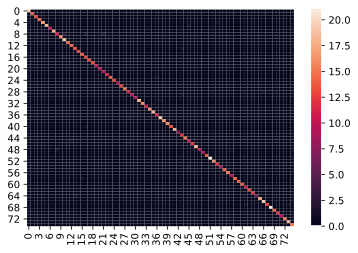

In [30]:
import seaborn as sns
sns.heatmap(confusion_matrix(y_test,predicted2))

In [31]:
print("Accuracy: %.2f  " % accuracy_score(y_test, predicted2,normalize=True))
print("F1-score: %.2f" % f1_score(y_test,predicted2,average='micro'))

Accuracy: 0.97  
F1-score: 0.97


In [32]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [33]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model2, X, y, cv=6,scoring='accuracy')

In [34]:
scores

array([0.95732575, 0.98719772, 0.95163585, 0.94301994, 0.95156695,
       0.95726496])

In [35]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.96 (+/- 0.03)


##Test Level

In [36]:
def pre(file,sample_rate):
    
    signal, sample_rate = librosa.load(file,sr=sample_rate)

                    #normalise the signal
    #signal=signal/np.max(signal)
                    
                    #Pre_emphasis
    signal=pre_emphasis(signal)

                    #VAD
    signal=VAD(signal,sample_rate)

                    # extract MFCC
    mfcc=get_MFCCs(signal)
                    
    return mfcc

In [57]:
file2="/content/drive/My Drive/Colab Notebooks/mix_27s (audio-joiner.com).wav"
file3="/content/drive/My Drive/Colab Notebooks/ElHajoui_mohamed55.wav"

In [58]:
unknow_speaker_1=pre(file2,16000)
unknow_speaker_47=pre(file3,16000)
#scaler = preprocessing.StandardScaler().fit(X_train)
#unknow_speaker_1=scaler.transform([unknow_speaker_1])
#unknow_speaker_47=scaler.transform([unknow_speaker_47])

In [59]:
prded=model1.predict_proba([unknow_speaker_47])

prd=np.argmax(prded)
with open(json_path, "r") as jp:
        data = json.load(jp)
speakers=data["speakers"]
print("the speaker predicted by our model is: Speaker {} avec une certainité de {} %".format(speakers[prd],np.max(prded)*100))

prded

the speaker predicted by our model is: Speaker El Hajoui mohamed avec une certainité de 70.40883866983425 %


array([[2.05133174e-02, 6.57628572e-03, 6.25783235e-04, 6.20761072e-04,
        8.26578279e-03, 1.57228935e-03, 6.42726980e-03, 4.33966711e-04,
        1.17361598e-03, 3.99107837e-03, 7.09984152e-04, 1.95755483e-03,
        4.26692088e-04, 1.43935977e-03, 2.73543676e-03, 4.25119131e-04,
        5.13164315e-04, 1.73869640e-03, 6.79632738e-04, 4.45771185e-04,
        8.59967531e-04, 3.13316484e-03, 4.09326675e-04, 1.10948852e-03,
        7.04088387e-01, 7.70552909e-03, 4.43699484e-03, 2.34242887e-03,
        1.02061706e-03, 4.52308869e-03, 1.44600061e-02, 2.13698235e-02,
        2.83212513e-02, 2.49844569e-03, 5.66183770e-04, 2.27275323e-03,
        1.03531371e-03, 9.50281259e-04, 2.29066271e-03, 3.95029448e-03,
        5.36370922e-04, 5.57696298e-04, 1.03348472e-03, 7.51562366e-04,
        8.05547738e-04, 9.53537256e-04, 8.77251628e-04, 7.65764307e-03,
        4.85750542e-04, 4.83819350e-04, 2.71878046e-02, 5.76418811e-04,
        1.01345452e-02, 2.43809055e-03, 1.39360316e-03, 5.753884

In [60]:
prd=model1.predict_proba([unknow_speaker_1])

ar=prd.flatten()

indx=ar.argsort()[-4:][::-1]

with open(json_path, "r") as jp:
        data = json.load(jp)

speakers=data["speakers"]

print("the speakers Talking in this conversation are :  {} , {} and {} and {}".format(speakers[indx[0]],speakers[indx[1]],speakers[indx[2]],speakers[indx[3]]))
prd

the speakers Talking in this conversation are :  Elamri Yassine , Zennou Mohammad and Aznour Omar and Ghazali Yassir


array([[0.00236181, 0.02711388, 0.00210279, 0.00220603, 0.09143129,
        0.00110363, 0.046266  , 0.00051597, 0.00402182, 0.00556039,
        0.00145896, 0.0138968 , 0.00045436, 0.00141125, 0.00575661,
        0.00069859, 0.0006903 , 0.01082914, 0.00726512, 0.00071841,
        0.00331131, 0.00846038, 0.00083426, 0.00070586, 0.00348269,
        0.00321678, 0.00254173, 0.30108025, 0.00525618, 0.00091979,
        0.01017517, 0.01872847, 0.0108705 , 0.08353875, 0.00103311,
        0.01128305, 0.00072521, 0.0134812 , 0.00093154, 0.00107476,
        0.00076013, 0.00059503, 0.00329988, 0.00053023, 0.00079171,
        0.00085356, 0.00193084, 0.00283305, 0.00069331, 0.00124835,
        0.00962976, 0.00132654, 0.02335102, 0.00257353, 0.00073102,
        0.00329695, 0.01282022, 0.00592139, 0.00173721, 0.00055862,
        0.0027325 , 0.00203945, 0.00741633, 0.00069792, 0.00192201,
        0.00168857, 0.0074065 , 0.0128196 , 0.00144865, 0.00053382,
        0.00252589, 0.0013295 , 0.00501036, 0.16